In [1]:
%matplotlib inline
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
sys.version_info

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)

In [4]:
from MomentMatching.newMomentMatch import UnscentedTransform, TaylorTransform, MonteCarloTransform
from MomentMatching.TimeSeriesModel import TimeSeriesModel, UniformNonlinearGrowthModel
from MomentMatching.StateModels import GaussianState
from ExpectationPropagation import EPNodes
from MomentMatching.ExpectationPropagation import TopEP
from Filters.KalmanFilter import KalmanFilterSmoother, PowerKalmanFilterSmoother
from Utils.Metrics import nll, rmse
from Utils.Plot_Helper import plot_gaussian, plot_gaussian_node
from Systems import BearingsOnlyTracking
import logging

In [49]:
SEED = 100

np.random.seed(seed=SEED)

N = 50
system = UniformNonlinearGrowthModel()
# system = BearingsOnlyTracking()
data = system.simulate(N)
x_true, x_noisy, y_true, y_noisy = zip(*data)


power = 1
damping = 1

transform = UnscentedTransform(n=1,  beta=0,  alpha=1, kappa=2)
meas_transform = UnscentedTransform(n=1, beta=0,  alpha=1, kappa=2)

In [87]:
def _power_sweep(power, damping):
    transform = UnscentedTransform(n=1, beta=0, alpha=1, kappa=1)
    meas_transform = UnscentedTransform(n=1, beta=0, alpha=1, kappa=1)
#     transform = TaylorTransform()
#     transform = MonteCarloTransform(number_of_samples=2000)
#     meas_transform = MonteCarloTransform(number_of_samples=2000)
    Nodes = EPNodes(dimension_of_state=1, N=N)
    EP = TopEP(system_model=system,
               moment_matching=transform,
               meas_transform=meas_transform,
               power=power,
               damping=damping)

    EPNodesList = EP.forward_backward_iteration(10, Nodes, y_noisy, list(range(0, N)), x_true)

    Node = [node.marginal for node in EPNodesList[-1]]
    return nll(Node, x_true), rmse(Node, x_true)

In [88]:
x = 10
y = 10
power_range = np.linspace(0.1, 1.0, num=x)
damp_range = np.linspace(0.1, 1.0, num=y)

In [89]:
power_range

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [90]:
results = []
NLL = []
RMSE = []
for power, damping in itertools.product(power_range, damp_range):
    ans = _power_sweep(power, damping)
    a1, a2 = ans
    NLL.append(a1)
    RMSE.append(a2)
    results.append(ans)

In [91]:
results

[(4.0058439554361227, 9.6006711011824368),
 (4.086519149556902, 9.6390619647597457),
 (4.1987355465683365, 9.5343767636639516),
 (4.203965780898093, 9.4584042098563632),
 (4.1876565479269177, 9.4720244873325843),
 (4.1581819416940347, 9.472714949528692),
 (4.0680745341180904, 9.5096132296843301),
 (4.0653620372362607, 9.5142616610885931),
 (4.0611311590136356, 9.527517502541798),
 (4.0483293037977539, 9.542242073374597),
 (4.0627264723758989, 9.4486594474165084),
 (4.0602031724217662, 9.3234592749806691),
 (4.0945424193874604, 9.3275625355372398),
 (4.0921093176552974, 9.2218517268728881),
 (4.1042473824263199, 9.2007037097909841),
 (4.1293257461653079, 9.271166321989595),
 (4.1119269387562181, 9.153600928352482),
 (4.0571392228006644, 9.1491200245776021),
 (3.991633148186263, 9.1039171796811278),
 (3.920144201471536, 9.3280845189097725),
 (4.0934582491475338, 10.108243085953346),
 (4.0901861228933036, 10.120896567940598),
 (4.0913668980995705, 10.097780356762156),
 (4.0436969402047787

In [92]:
len(results)

100

In [93]:
ll = np.array(NLL)
Rmse = np.array(RMSE)

In [94]:
ind_ll = np.array(list(itertools.product(power_range, damp_range)))

In [95]:
ind_ll.reshape(x, y, 2)[0]

array([[ 0.1,  0.1],
       [ 0.1,  0.2],
       [ 0.1,  0.3],
       [ 0.1,  0.4],
       [ 0.1,  0.5],
       [ 0.1,  0.6],
       [ 0.1,  0.7],
       [ 0.1,  0.8],
       [ 0.1,  0.9],
       [ 0.1,  1. ]])

In [96]:

img_ll = ll.reshape(x, y)
img_rmse = Rmse.reshape(x, y)

In [97]:
np.argmin(img_ll)

84

In [98]:
ind_ll[np.argmin(img_ll)]

array([ 0.9,  0.5])

In [99]:
ind_ll[np.argmax(img_ll)]

array([ 1.,  1.])

In [100]:
ind_ll[3]

array([ 0.1,  0.4])

In [101]:
NLL[3]

4.203965780898093

In [102]:
_power_sweep(0.1, 0.4)

(4.203965780898093, 9.4584042098563632)

In [103]:
img_rmse[6][4]

2.6898087866617146

In [104]:
np.max(img_rmse)

16.192592554813807

In [105]:
methods = [None, 'none','nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

In [106]:
len(methods)

18

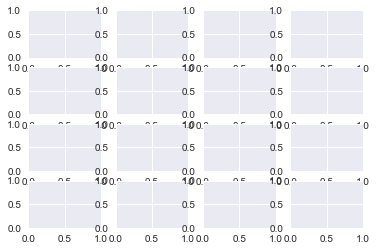

In [107]:
fig, ax = plt.subplots(4,4)

In [108]:
ax[0]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b2f2906d8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7b2ede2e80>], dtype=object)

In [109]:
def plot(img, methods):
    plt.imshow(img_ll, interpolation=methods[9], extent=[0.0,1,0.0,1], cmap='jet', clim=(0, 6))
    ax = plt.gca()
    ax.set_xlabel('Power')
    ax.set_ylabel('Damping')
    ax.grid(False)
    plt.colorbar()

In [110]:
log_nll = np.log(img_ll)

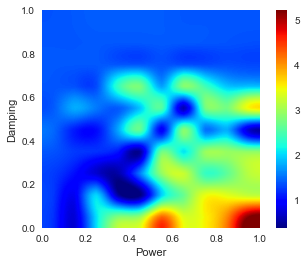

In [111]:
plt.imshow(log_nll, interpolation=methods[5], extent=[0.0,1,0.0,1], cmap='jet', vmax=np.max(log_nll), vmin=np.min(log_nll))
ax = plt.gca()
ax.set_xlabel('Power')
ax.set_ylabel('Damping')
ax.grid(False)
plt.colorbar()

In [112]:
log_rmse = np.log(img_rmse)

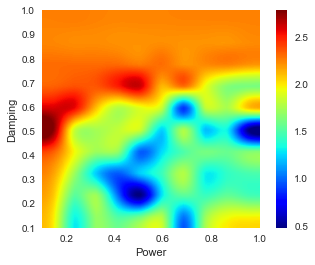

In [113]:
plt.imshow(log_rmse, interpolation=methods[5], extent=[0.1,1,0.1,1], cmap='jet', vmax=np.max(log_rmse), vmin=np.min(log_rmse))
ax = plt.gca()
ax.set_xlabel('Power')
ax.set_ylabel('Damping')
ax.grid(False)
plt.colorbar()

In [33]:
dx

NameError: name 'dx' is not defined

In [ ]:
x_plot, y_plot = np.mgrid[0.1:1.1:0.1, 0.1:1.1:0.1]

In [ ]:
plt.pcolor( y_plot, x_plot, log_rmse, cmap='RdBu' )
plt.colorbar()
# plt.axis([x_plot.min(), x_plot.max(), y_plot.min(), y_plot.max()])

In [ ]:
for i in range(len(power_range)):
    plt.plot(power_range, img_ll[:, i])

In [ ]:
Rmse